<a href="https://colab.research.google.com/github/mihayy/review_aspect_score_prediction/blob/master/results/results.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Results

In [0]:
import numpy as np
import pandas as pd
from pathlib import Path
import pickle

In [2]:
from google.colab import drive
drive.mount('gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at gdrive


In [0]:
class Config(object):
  def __init__(self):
    self.gdrive_working_dir = Path("gdrive/My Drive/thesis")

    self.embeddings_path = self.gdrive_working_dir/ "embeddings"

#     self.dataset_intermediate_path = Path("manual_labeled_strength_weak_sections/summary_strength_weak_sections")
    self.dataset_intermediate_path = Path("")

#     self.dataset_intermediate_path = Path("manual_labeled_strength_weak_sections")
#     self.dataset_intermediate_path = Path("acl_abstracts")
    self.dataset_path = self.gdrive_working_dir/ "data" / self.dataset_intermediate_path

    self.train_dataset_filename = "train_dataset.csv"
    self.dev_dataset_filename = "dev_dataset.csv"
    self.test_dataset_filename = "acl_dev_test.csv"
    
    self.train_ds = "train_ds_"
    self.test_ds = "test_ds_"

    self.aspects_no_com_approp = ['RECOMMENDATION', 'REVIEWER_CONFIDENCE', 'SOUNDNESS_CORRECTNESS', 'IMPACT', 'SUBSTANCE', 'CLARITY', 'ORIGINALITY']
    
    self.stats_path = self.gdrive_working_dir / "tensorflow_stats_random"
#     self.stats_path = Path("")
    
  def set_dataset_intermediate_path(self, intermediate_path):
    self.dataset_intermediate_path = intermediate_path
    self.dataset_path = self.gdrive_working_dir/ "data" / self.dataset_intermediate_path
    
  def set_ds_fname(self, iteration):
    self.train_dataset_filename = self.train_ds + str(iteration) + ".csv"
    self.dev_dataset_filename = self.test_ds + str(iteration) + ".csv"

In [0]:
env_var = Config()

In [0]:
dataset_intermediate_paths =[Path(""),
                             Path("strength_weak_sections"),
                             Path("manual_labeled_strength_weak_sections"),
                             Path("manual_labeled_strength_weak_sections/first_section"),
                             Path("manual_labeled_strength_weak_sections/strength_weak_sections"),
                             Path("manual_labeled_strength_weak_sections/strength_weak_sections_len_limit"),
                             Path("manual_labeled_strength_weak_sections/summary_strength_weak_sections"),
                             Path("manual_labeled_strength_weak_sections/summary_strength_weak_sections/clarity_sentences"),
                             Path("manual_labeled_strength_weak_sections/weak_section"),
                             Path("manual_labeled_strength_weak_sections/weak_strength_sections_len_limit"),
                             Path("manual_labeled_strength_weak_sections/aug_stren_weak_sections_len_limit"),
                             Path("manual_labeled_strength_weak_sections/strength_section"),
                             Path("acl_abstracts")
                            ]

In [0]:
dataset_intermediate_paths_mapping ={Path(""):"original",
                                     Path("strength_weak_sections"):"str_weak",
                                     Path("manual_labeled_strength_weak_sections"):"manual*",
                                     Path("manual_labeled_strength_weak_sections/first_section"):"sum*",
                                     Path("manual_labeled_strength_weak_sections/strength_weak_sections"):"str_weak*",
                                     Path("manual_labeled_strength_weak_sections/strength_weak_sections_len_limit"):"str_weak_limit*",
                                     Path("manual_labeled_strength_weak_sections/summary_strength_weak_sections"):"sum_str_weak*",
                                     Path("manual_labeled_strength_weak_sections/summary_strength_weak_sections/clarity_sentences"):"clarity*",
                                     Path("manual_labeled_strength_weak_sections/weak_section"):"weak*",
                                     Path("manual_labeled_strength_weak_sections/weak_strength_sections_len_limit"):"weak_str_limit*",
                                     Path("manual_labeled_strength_weak_sections/aug_stren_weak_sections_len_limit"):"limit_aug*",
                                     Path("manual_labeled_strength_weak_sections/strength_section"):"str*",
                                     Path("acl_abstracts"):"abstract"
                                    }

aspect_mapping = {'RECOMMENDATION':"RECOMMEND",
 'REVIEWER_CONFIDENCE':"CONFIDEN",
 'SOUNDNESS_CORRECTNESS':"CORRECT",
 }

In [0]:
class Epoch_Metrics():
  def __init__(self, conf_matrix, accuracy, loss):
    self.conf_matrix = conf_matrix
    self.accuracy = accuracy
    self.loss = loss
    
    
class Stat():
  def __init__(self, epoch, train_metrics, dev_metrics, test_metrics, iteration):
    self.epoch = epoch    
    self.train_accuracy = train_metrics.accuracy
    self.dev_accuracy = dev_metrics.accuracy
    self.train_loss = train_metrics.loss
    self.dev_loss = dev_metrics.loss
    self.test_accuracy = test_metrics.accuracy
    self.dev_conf_matrix = dev_metrics.conf_matrix
    self.test_conf_matrix = test_metrics.conf_matrix
    self.iteration = iteration
    
  def __str__(self):
    return f'{self.epoch} Train accuracy: {self.train_accuracy} Dev accuracy: {self.dev_accuracy} Train loss: {self.train_loss} Dev loss: {self.dev_loss}, Test acc: {self.test_accuracy}'


In [0]:
import operator

class Model_stats(object):
  def __init__(self, dataset_intermediate_path, model_name, aspect_label_name):
    self.dataset_intermediate_path = dataset_intermediate_path
    self.model_name = model_name
    self.aspect_label_name = aspect_label_name
    self.stats = []
    
  def compute_mean_metrics(self):
    top_3_dev_acc_stats = sorted(self.stats, key=operator.attrgetter('dev_accuracy'), reverse=True)[:3]
    
    self.mean_convergence_epoch = np.mean([stat.epoch for stat in self.stats]) 
    
    self.mean_dev_accuracy = np.mean([stat.dev_accuracy for stat in self.stats]) 
    self.mean_test_accuracy = np.mean([stat.test_accuracy for stat in self.stats]) 
    
    self.std_dev_accuracy = np.std([stat.dev_accuracy for stat in self.stats]) 
    self.std_test_accuracy = np.std([stat.test_accuracy for stat in self.stats]) 
    
    self.top_3_mean_dev_accuracy = np.mean([stat.dev_accuracy for stat in top_3_dev_acc_stats]) 
    self.top_3_mean_test_accuracy = np.mean([stat.test_accuracy for stat in top_3_dev_acc_stats]) 
    
    self.best_dev_acc_stats = top_3_dev_acc_stats[0]
    self.best_epoch_dev_conf_matrix = self.best_dev_acc_stats.dev_conf_matrix
    self.best_epoch_test_conf_matrix = self.best_dev_acc_stats.test_conf_matrix    

In [0]:
tf_stats_fname = env_var.gdrive_working_dir / "tensorflow_stats_random" / "tensorflow_models_stats.p"

ulmfit_stats_fname = env_var.gdrive_working_dir / "ulmfit_stats_random" / "ulmfit_stats.p"

rf_stats_fname = env_var.gdrive_working_dir / "simple_stats_random" / "rf_stats.p"

mv_stats_fname = env_var.gdrive_working_dir / "simple_stats_random" / "mv_stats.p"

In [0]:
with open(tf_stats_fname, "rb") as input_file:
  tf_stats = pickle.load(input_file)
    
with open(ulmfit_stats_fname, "rb") as input_file:
  ulmfit_stats = pickle.load(input_file)
  
with open(rf_stats_fname, "rb") as input_file:
  rf_stats = pickle.load(input_file)
  
with open(mv_stats_fname, "rb") as input_file:
  mv_stats = pickle.load(input_file)

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

manipulations_order = [
  "original",
  "manual*", 
  "str_weak",           
  "sum_str_weak*", 
  "str_weak*",  
  "sum*", 
  "weak*", 
  "str*", 
  "str_weak_limit*", 
  "weak_str_limit*", 
  "limit_aug*", 
  "clarity*", 
  "abstract"]

models = ["CNN", "RNN", "MTL_RNN", "Cond_RNN", "ULMFiT"]

nrows_aspect, ncols_aspect = (4, 2)

ax_list_aspect = [i for i in np.ndindex((nrows_aspect,ncols_aspect))]

In [12]:
models_records = []
for model_stat in ulmfit_stats:
  for idx, stat in enumerate(model_stat.stats):
    models_records += [(stat.iteration, "ULMFiT", model_stat.aspect_label_name, stat.dev_accuracy, stat.epoch, model_stat.dataset_intermediate_path)]

for model_stat in tf_stats:
  for idx, stat in enumerate(model_stat.stats):
    models_records += [(stat.iteration, model_stat.model_name, model_stat.aspect_label_name, stat.dev_accuracy, stat.epoch, model_stat.dataset_intermediate_path)]

for model_stat in rf_stats:
  for idx, stat in enumerate(model_stat.stats):
    models_records += [(stat.iteration, "RF", model_stat.aspect_label_name, stat.dev_accuracy, stat.epoch, model_stat.dataset_intermediate_path)]

for model_stat in mv_stats:
  for idx, stat in enumerate(model_stat.stats):
    models_records += [(stat.iteration, "MV", model_stat.aspect_label_name, stat.dev_accuracy, stat.epoch, model_stat.dataset_intermediate_path)]
    
df = pd.DataFrame.from_records(models_records, columns=["Iteration", 'Model', "Aspect", 'Accuracy', "Epoch", "Manipulation"])

df = df.replace({"Manipulation":dataset_intermediate_paths_mapping})

df.head()

,Iteration,Model,Aspect,Accuracy,Epoch,Manipulation
0,0,ULMFiT,RECOMMENDATION,0.611111,8,original
1,1,ULMFiT,RECOMMENDATION,0.462963,7,original
2,2,ULMFiT,RECOMMENDATION,0.648148,10,original
3,3,ULMFiT,RECOMMENDATION,0.592593,14,original
4,4,ULMFiT,RECOMMENDATION,0.574074,9,original


In [0]:
df_all_epoch_no_0 = df[((df.Epoch != 0) | (df.Model == "MV") | (df.Model == "RF"))]

df_all_simple = df[((df.Model == "MV") | (df.Model == "RF"))]

df_all_original_epoch_no_0 = df[((df.Epoch != 0) | (df.Model == "MV") | (df.Model == "RF")) & (df.Manipulation == "original")]

df_all_abstract_epoch_no_0 = df[((df.Epoch != 0) | (df.Model == "MV") | (df.Model == "RF")) & (df.Manipulation == "abstract")]

df_all_no_abstract_original_epoch_no_0 = df[((df.Epoch != 0) | (df.Model == "MV") | (df.Model == "RF")) & (df.Manipulation != "abstract") & (df.Manipulation != "original")]

df_all_no_original_epoch_no_0 = df[((df.Epoch != 0) | (df.Model == "MV") | (df.Model == "RF")) & (df.Manipulation != "original")]

df_all_no_abstract_epoch_no_0 = df[((df.Epoch != 0) | (df.Model == "MV") | (df.Model == "RF")) & (df.Manipulation != "abstract")]

df_all_no_abstract_original_manual_epoch_no_0 = df[((df.Epoch != 0) | (df.Model == "MV") | (df.Model == "RF")) & (df.Manipulation != "abstract") & (df.Manipulation != "original") & (df.Manipulation != "manual*")]

df_all_no_original_manual_epoch_no_0 = df[((df.Epoch != 0) | (df.Model == "MV") | (df.Model == "RF")) & (df.Manipulation != "manual*") & (df.Manipulation != "original")]

df_all_on_abstract_sum_str_weak_rnn_ulmfit = df[(df.Epoch != 0) & ((df.Manipulation == "abstract") | (df.Manipulation == "sum_str_weak*")) & ((df.Model == "ULMFiT") | (df.Model == "RNN"))]

In [14]:
df_all_epoch_no_0.groupby(["Model", "Aspect", "Manipulation"], sort=False).agg({"Accuracy":"median"}).unstack()

Accuracy            ...                    
Manipulation                    original  str_weak  ...      str*  abstract
Model    Aspect                                     ...                    
ULMFiT   RECOMMENDATION         0.592593  0.564815  ...  0.564815  0.558824
         REVIEWER_CONFIDENCE    0.601852  0.564815  ...  0.583333  0.598077
         SOUNDNESS_CORRECTNESS  0.564815  0.555556  ...  0.527778  0.588077
         IMPACT                 0.805556  0.805556  ...  0.796296  0.821765
         SUBSTANCE              0.592593  0.629630  ...  0.611111  0.643529
         CLARITY                0.453704  0.462963  ...  0.462963  0.500000
         ORIGINALITY            0.518519  0.472222  ...  0.425926  0.515098
CNN      RECOMMENDATION         0.518519  0.518519  ...  0.527778  0.524706
         REVIEWER_CONFIDENCE    0.574074  0.574074  ...  0.537037  0.529412
         SOUNDNESS_CORRECTNESS  0.462963  0.481481  ...  0.500000  0.484694
         IMPACT                 0.777778  0.759259  ...  0.750000  0.752353
         SUBSTANCE              0.592593  0.574074  ...  0.574074  0.580000
         CLARITY                0.435185  0.453704  ...  0.416667  0.470000
         ORIGINALITY            0.416667  0.425926  ...  0.444444  0.470000
RNN      RECOMMENDATION         0.537037  0.518519  ...  0.527778  0.509804
         REVIEWER_CONFIDENCE    0.564815  0.555556  ...  0.574074  0.588077
         SOUNDNESS_CORRECTNESS  0.518519  0.453704  ...  0.509259  0.604118
         IMPACT                 0.796296  0.796296  ...  0.796296  0.821765
         SUBSTANCE              0.592593  0.564815  ...  0.583333  0.588235
         CLARITY                0.509259  0.398148  ...  0.416667  0.485098
         ORIGINALITY            0.462963  0.398148  ...  0.407407  0.524510
MTL_RNN  RECOMMENDATION         0.500000  0.500000  ...  0.500000  0.519231
         REVIEWER_CONFIDENCE    0.574074  0.555556  ...  0.500000  0.509804
         SOUNDNESS_CORRECTNESS  0.416667  0.444444  ...  0.425926  0.574176
         IMPACT                 0.777778  0.740741  ...  0.759259  0.760000
         SUBSTANCE              0.574074  0.574074  ...  0.555556  0.505294
         CLARITY                0.416667  0.407407  ...  0.398148  0.465294
         ORIGINALITY            0.490741  0.388889  ...  0.407407  0.495294
Cond_RNN RECOMMENDATION         0.509259  0.518519  ...  0.388889  0.401961
         REVIEWER_CONFIDENCE    0.481481  0.509259  ...  0.342593  0.401923
         SOUNDNESS_CORRECTNESS  0.444444  0.425926  ...  0.361111  0.393878
         IMPACT                 0.796296  0.796296  ...  0.657407  0.550000
         SUBSTANCE              0.583333  0.564815  ...  0.574074  0.574314
         CLARITY                0.407407  0.416667  ...  0.351852  0.340000
         ORIGINALITY            0.379630  0.370370  ...  0.379630  0.420168
RF       RECOMMENDATION         0.527778  0.527778  ...  0.518519  0.539216
         REVIEWER_CONFIDENCE    0.592593  0.592593  ...  0.592593  0.588077
         SOUNDNESS_CORRECTNESS  0.500000  0.453704  ...  0.416667  0.424082
         IMPACT                 0.796296  0.796296  ...  0.796296  0.821765
         SUBSTANCE              0.583333  0.583333  ...  0.583333  0.623725
         CLARITY                0.435185  0.425926  ...  0.425926  0.474898
         ORIGINALITY            0.379630  0.379630  ...  0.388889  0.287255
MV       RECOMMENDATION         0.527778  0.527778  ...  0.527778  0.539216
         REVIEWER_CONFIDENCE    0.592593  0.592593  ...  0.592593  0.588077
         SOUNDNESS_CORRECTNESS  0.462963  0.462963  ...  0.462963  0.393878
         IMPACT                 0.796296  0.796296  ...  0.796296  0.821765
         SUBSTANCE              0.583333  0.583333  ...  0.583333  0.623725
         CLARITY                0.416667  0.416667  ...  0.416667  0.474898
         ORIGINALITY            0.379630  0.379630  ...  0.379630  0.440000

[49 rows x 13 columns]

In [15]:
df_all_epoch_no_0.groupby(["Manipulation", "Aspect", "Model"], sort=False).agg({"Accuracy":"median"}).unstack()

Accuracy            ...                    
Model                                    ULMFiT       CNN  ...        RF        MV
Manipulation    Aspect                                     ...                    
original        RECOMMENDATION         0.592593  0.518519  ...  0.527778  0.527778
                REVIEWER_CONFIDENCE    0.601852  0.574074  ...  0.592593  0.592593
                SOUNDNESS_CORRECTNESS  0.564815  0.462963  ...  0.500000  0.462963
                IMPACT                 0.805556  0.777778  ...  0.796296  0.796296
                SUBSTANCE              0.592593  0.592593  ...  0.583333  0.583333
                CLARITY                0.453704  0.435185  ...  0.435185  0.416667
                ORIGINALITY            0.518519  0.416667  ...  0.379630  0.379630
str_weak        RECOMMENDATION         0.564815  0.518519  ...  0.527778  0.527778
                REVIEWER_CONFIDENCE    0.564815  0.574074  ...  0.592593  0.592593
                SOUNDNESS_CORRECTNESS  0.555556  0.481481  ...  0.453704  0.462963
                IMPACT                 0.805556  0.759259  ...  0.796296  0.796296
                SUBSTANCE              0.629630  0.574074  ...  0.583333  0.583333
                CLARITY                0.462963  0.453704  ...  0.425926  0.416667
                ORIGINALITY            0.472222  0.425926  ...  0.379630  0.379630
manual*         RECOMMENDATION         0.592593  0.518519  ...  0.527778  0.527778
                REVIEWER_CONFIDENCE    0.601852  0.564815  ...  0.592593  0.592593
                SOUNDNESS_CORRECTNESS  0.574074  0.490741  ...  0.490741  0.462963
                IMPACT                 0.814815  0.759259  ...  0.796296  0.796296
                SUBSTANCE              0.601852  0.564815  ...  0.583333  0.583333
                CLARITY                0.462963  0.453704  ...  0.435185  0.416667
                ORIGINALITY            0.490741  0.453704  ...  0.379630  0.379630
sum*            RECOMMENDATION         0.583333  0.509259  ...  0.527778  0.527778
                REVIEWER_CONFIDENCE    0.583333  0.583333  ...  0.592593  0.592593
                SOUNDNESS_CORRECTNESS  0.537037  0.481481  ...  0.472222  0.462963
                IMPACT                 0.796296  0.768519  ...  0.796296  0.796296
                SUBSTANCE              0.611111  0.583333  ...  0.583333  0.583333
                CLARITY                0.462963  0.444444  ...  0.407407  0.416667
                ORIGINALITY            0.500000  0.453704  ...  0.379630  0.379630
str_weak*       RECOMMENDATION         0.574074  0.527778  ...  0.527778  0.527778
                REVIEWER_CONFIDENCE    0.583333  0.555556  ...  0.592593  0.592593
...                                         ...       ...  ...       ...       ...
weak*           CLARITY                0.462963  0.444444  ...  0.425926  0.416667
                ORIGINALITY            0.444444  0.425926  ...  0.388889  0.379630
weak_str_limit* RECOMMENDATION         0.574074  0.490741  ...  0.527778  0.527778
                REVIEWER_CONFIDENCE    0.574074  0.583333  ...  0.592593  0.592593
                SOUNDNESS_CORRECTNESS  0.564815  0.453704  ...  0.388889  0.462963
                IMPACT                 0.796296  0.777778  ...  0.796296  0.796296
                SUBSTANCE              0.592593  0.574074  ...  0.583333  0.583333
                CLARITY                0.481481  0.416667  ...  0.435185  0.416667
                ORIGINALITY            0.435185  0.407407  ...  0.361111  0.379630
limit_aug*      RECOMMENDATION         0.537037  0.500000  ...  0.527778  0.527778
                REVIEWER_CONFIDENCE    0.583333  0.574074  ...  0.592593  0.592593
                SOUNDNESS_CORRECTNESS  0.527778  0.472222  ...  0.407407  0.462963
                IMPACT                 0.814815  0.759259  ...  0.796296  0.796296
                SUBSTANCE              0.592593  0.574074  ...  0.583333  0.583333
                CLARITY                0.444444  0.4074

In [0]:
print(df_all_epoch_no_0.replace({"Aspect":aspect_mapping}).groupby(["Manipulation", "Aspect", "Model"], sort=False).agg({"Accuracy":"median"}).unstack().round(4).to_latex(longtable=True))

In [0]:
# df_all_epoch_no_0.groupby(["Manipulation", "Model", "Aspect"], sort=False).agg({"Accuracy":"median"}).unstack()

#### Aggregated Aspects Model Performance

#### Best things

In [26]:
# best moanipulation on agg aspect models
df_all_epoch_no_0.groupby(["Manipulation", "Model", "Aspect"], sort=False).agg({"Accuracy":"median"}).unstack().mean(axis=1).unstack()

Model,ULMFiT,CNN,RNN,MTL_RNN,Cond_RNN,RF,MV
Manipulation,,,,,,,
original,0.589947,0.539683,0.568783,0.535714,0.514550,0.544974,0.537037
str_weak,0.579365,0.541005,0.526455,0.515873,0.514550,0.537037,0.537037
manual*,0.591270,0.543651,0.558201,0.537037,0.522487,0.543651,0.537037
sum*,0.582011,0.546296,0.543651,0.526455,0.448413,0.537037,0.537037
str_weak*,0.568783,0.527778,0.533069,0.502646,0.522487,0.530423,0.537037
str_weak_limit*,0.574074,0.544974,0.511905,0.506614,0.522487,0.531746,0.537037
sum_str_weak*,0.591270,0.527778,0.525132,0.514550,0.519841,0.535714,0.537037
clarity*,0.556878,0.539683,0.530423,0.503968,0.474868,0.529101,0.537037
weak*,0.556878,0.535714,0.525132,0.526455,0.511905,0.531746,0.537037


In [0]:
# best moanipulation on agg aspect models
print(df_all_epoch_no_0.groupby(["Manipulation", "Model", "Aspect"], sort=False).agg({"Accuracy":"median"}).unstack().mean(axis=1).unstack().max(axis=1).sort_values(ascending=False).round(4).to_latex())

In [18]:
df_all_epoch_no_0.groupby(["Manipulation", "Model", "Aspect"], sort=False).agg({"Accuracy":"median"}).unstack().mean(axis=1).unstack().T

Manipulation,original,str_weak,manual*,sum*,str_weak*,str_weak_limit*,sum_str_weak*,clarity*,weak*,weak_str_limit*,limit_aug*,str*,abstract
Model,,,,,,,,,,,,,
ULMFiT,0.589947,0.579365,0.591270,0.582011,0.568783,0.574074,0.591270,0.556878,0.556878,0.574074,0.567460,0.567460,0.603624
CNN,0.539683,0.541005,0.543651,0.546296,0.527778,0.544974,0.527778,0.539683,0.535714,0.529101,0.534392,0.535714,0.544452
RNN,0.568783,0.526455,0.558201,0.543651,0.533069,0.511905,0.525132,0.530423,0.525132,0.529101,0.531746,0.544974,0.588801
MTL_RNN,0.535714,0.515873,0.537037,0.526455,0.502646,0.506614,0.514550,0.503968,0.526455,0.514550,0.510582,0.506614,0.547013
Cond_RNN,0.514550,0.514550,0.522487,0.448413,0.522487,0.522487,0.519841,0.474868,0.511905,0.523810,0.521164,0.436508,0.440320
RF,0.544974,0.537037,0.543651,0.537037,0.530423,0.531746,0.535714,0.529101,0.531746,0.526455,0.529101,0.531746,0.537002
MV,0.537037,0.537037,0.537037,0.537037,0.537037,0.537037,0.537037,0.537037,0.537037,0.537037,0.537037,0.537037,0.554508


In [27]:
# best model with abstract on agg aspect models
df_all_epoch_no_0.groupby(["Manipulation", "Model", "Aspect"], sort=False).agg({"Accuracy":"median"}).unstack().mean(axis=1).unstack().T.max(axis=1).sort_values(ascending=False).round(4)

Manipulation,original,str_weak,manual*,sum*,str_weak*,str_weak_limit*,sum_str_weak*,clarity*,weak*,weak_str_limit*,limit_aug*,str*,abstract
Model,,,,,,,,,,,,,
ULMFiT,0.589947,0.579365,0.591270,0.582011,0.568783,0.574074,0.591270,0.556878,0.556878,0.574074,0.567460,0.567460,0.603624
CNN,0.539683,0.541005,0.543651,0.546296,0.527778,0.544974,0.527778,0.539683,0.535714,0.529101,0.534392,0.535714,0.544452
RNN,0.568783,0.526455,0.558201,0.543651,0.533069,0.511905,0.525132,0.530423,0.525132,0.529101,0.531746,0.544974,0.588801
MTL_RNN,0.535714,0.515873,0.537037,0.526455,0.502646,0.506614,0.514550,0.503968,0.526455,0.514550,0.510582,0.506614,0.547013
Cond_RNN,0.514550,0.514550,0.522487,0.448413,0.522487,0.522487,0.519841,0.474868,0.511905,0.523810,0.521164,0.436508,0.440320
RF,0.544974,0.537037,0.543651,0.537037,0.530423,0.531746,0.535714,0.529101,0.531746,0.526455,0.529101,0.531746,0.537002
MV,0.537037,0.537037,0.537037,0.537037,0.537037,0.537037,0.537037,0.537037,0.537037,0.537037,0.537037,0.537037,0.554508


In [20]:
# best model no abstract on agg aspect models
df_all_no_abstract_epoch_no_0.groupby(["Manipulation", "Model", "Aspect"], sort=False).agg({"Accuracy":"median"}).unstack().mean(axis=1).unstack().T.max(axis=1).sort_values(ascending=False).round(4)

Model
ULMFiT      0.5913
RNN         0.5688
CNN         0.5463
RF          0.5450
MTL_RNN     0.5370
MV          0.5370
Cond_RNN    0.5238
dtype: float64

In [0]:
# best maniplation
df_all_epoch_no_0.groupby(["Aspect", "Model", "Manipulation"], sort=False).agg({"Accuracy":"median"}).unstack().max(axis=1).unstack()

Model,ULMFiT,CNN,RNN,MTL_RNN,Cond_RNN,RF,MV
Aspect,,,,,,,
RECOMMENDATION,0.592593,0.527778,0.555556,0.519231,0.518519,0.539216,0.539216
REVIEWER_CONFIDENCE,0.601852,0.583333,0.588077,0.574074,0.546296,0.592593,0.592593
SOUNDNESS_CORRECTNESS,0.588077,0.509259,0.604118,0.574176,0.490741,0.500000,0.462963
IMPACT,0.824074,0.777778,0.821765,0.777778,0.796296,0.821765,0.821765
SUBSTANCE,0.643529,0.592593,0.601852,0.592593,0.583333,0.623725,0.623725
CLARITY,0.500000,0.470000,0.509259,0.465294,0.444444,0.474898,0.474898
ORIGINALITY,0.518519,0.470000,0.524510,0.495294,0.420168,0.388889,0.440000


In [0]:
# best single model on best manipulation 
df_all_epoch_no_0.groupby(["Model", "Aspect", "Manipulation"], sort=False).agg({"Accuracy":"median"}).unstack().max(axis=1).unstack().mean(axis=1).sort_values(ascending=False)

Model
ULMFiT      0.609806
RNN         0.600734
MTL_RNN     0.571206
MV          0.565023
RF          0.563012
CNN         0.561534
Cond_RNN    0.542828
dtype: float64

In [0]:
# best from all models combined 
# df_all_epoch_no_0.groupby(["Model", "Aspect", "Manipulation"], sort=False).agg({"Accuracy":"median"}).unstack().max(axis=1).unstack().T.max(axis=1).mean()

In [40]:
# best of baseline
df_all_simple.groupby(["Aspect", "Model", "Manipulation"], sort=False).agg({"Accuracy":"median"}).unstack().max(axis=1).unstack().max(axis=1).sort_values(ascending=False)
round(df_all_simple.groupby(["Aspect", "Model", "Manipulation"], sort=False).agg({"Accuracy":"median"}).unstack().max(axis=1).unstack().max(axis=1).sort_values(ascending=False).mean(), 5)

0.57031

In [41]:
# best result of all models only on original ds
df_all_original_epoch_no_0.groupby(["Aspect", "Model"], sort=False).agg({"Accuracy":"median"}).unstack().max(axis=1).sort_values(ascending=False)
round(df_all_original_epoch_no_0.groupby(["Aspect", "Model"], sort=False).agg({"Accuracy":"median"}).unstack().max(axis=1).sort_values(ascending=False).mean(), 5)

0.59788

In [51]:
# best result on all models no abstract, original, manual

round(df_all_no_abstract_original_manual_epoch_no_0.groupby(["Aspect", "Model", "Manipulation"], sort=False).agg({"Accuracy":"median"}).unstack().max(axis=1).unstack().max(axis=1).mean(), 5)

0.59921

In [50]:
# best result of all models on manipulations (with no abstract and no original)
df_all_no_abstract_original_epoch_no_0.groupby(["Aspect", "Model", "Manipulation"], sort=False).agg({"Accuracy":"median"}).unstack().max(axis=1).unstack().max(axis=1).sort_values(ascending=False)
round(df_all_no_abstract_original_epoch_no_0.groupby(["Aspect", "Model", "Manipulation"], sort=False).agg({"Accuracy":"median"}).unstack().max(axis=1).unstack().max(axis=1).sort_values(ascending=False).mean(), 5)

0.60317

In [43]:
# best result of all models except abstract
df_all_no_abstract_epoch_no_0.groupby(["Aspect", "Model", "Manipulation"], sort=False).agg({"Accuracy":"median"}).unstack().max(axis=1).unstack().max(axis=1).sort_values(ascending=False)
round(df_all_no_abstract_epoch_no_0.groupby(["Aspect", "Model", "Manipulation"], sort=False).agg({"Accuracy":"median"}).unstack().max(axis=1).unstack().max(axis=1).sort_values(ascending=False).mean(), 5)

0.60714

In [44]:
# best result of all models only on abstract
df_all_abstract_epoch_no_0.groupby(["Aspect", "Model"], sort=False).agg({"Accuracy":"median"}).unstack().max(axis=1).sort_values(ascending=False)
round(df_all_abstract_epoch_no_0.groupby(["Aspect", "Model"], sort=False).agg({"Accuracy":"median"}).unstack().max(axis=1).sort_values(ascending=False).mean(), 5)

0.60726

In [57]:
# on_abstract_sum_str_weak
round(df_all_on_abstract_sum_str_weak_rnn_ulmfit.groupby(["Aspect", "Model", "Manipulation"], sort=False).agg({"Accuracy":"median"}).unstack().max(axis=1).unstack().max(axis=1).mean(), 5)

0.60845

In [52]:
# best result on all models no orginal, manual
round(df_all_no_original_manual_epoch_no_0.groupby(["Aspect", "Model", "Manipulation"], sort=False).agg({"Accuracy":"median"}).unstack().max(axis=1).unstack().max(axis=1).mean(), 5)

0.61109

In [53]:
# best result of all models except original
df_all_no_original_epoch_no_0.groupby(["Aspect", "Model", "Manipulation"], sort=False).agg({"Accuracy":"median"}).unstack().max(axis=1).unstack().max(axis=1).sort_values(ascending=False)
round(df_all_no_original_epoch_no_0.groupby(["Aspect", "Model", "Manipulation"], sort=False).agg({"Accuracy":"median"}).unstack().max(axis=1).unstack().max(axis=1).sort_values(ascending=False).mean(), 5)

0.61295

In [54]:
# best result on all models on all ds
df_all_epoch_no_0.groupby(["Aspect", "Model", "Manipulation"], sort=False).agg({"Accuracy":"median"}).unstack().max(axis=1).unstack().max(axis=1).sort_values(ascending=False)
round(df_all_epoch_no_0.groupby(["Aspect", "Model", "Manipulation"], sort=False).agg({"Accuracy":"median"}).unstack().max(axis=1).unstack().max(axis=1).mean(), 5)

0.61428

## General plots

#### Aspect Avg Model Perormance plot 

In [0]:
df_all_epoch_no_0.groupby(["Manipulation", "Model", "Aspect"], sort=False).agg({"Accuracy":"median"}).unstack().mean(axis=1).unstack().T

Manipulation,original,str_weak,manual*,sum*,str_weak*,str_weak_limit*,sum_str_weak*,clarity*,weak*,weak_str_limit*,limit_aug*,str*,abstract
Model,,,,,,,,,,,,,
ULMFiT,0.589947,0.579365,0.591270,0.582011,0.568783,0.574074,0.591270,0.556878,0.556878,0.574074,0.567460,0.567460,0.603624
CNN,0.539683,0.541005,0.543651,0.546296,0.527778,0.544974,0.527778,0.539683,0.535714,0.529101,0.534392,0.535714,0.544452
RNN,0.568783,0.526455,0.558201,0.543651,0.533069,0.511905,0.525132,0.530423,0.525132,0.529101,0.531746,0.544974,0.588801
MTL_RNN,0.535714,0.515873,0.537037,0.526455,0.502646,0.506614,0.514550,0.503968,0.526455,0.514550,0.510582,0.506614,0.547013
Cond_RNN,0.514550,0.514550,0.522487,0.448413,0.522487,0.522487,0.519841,0.474868,0.511905,0.523810,0.521164,0.436508,0.440320
RF,0.544974,0.537037,0.543651,0.537037,0.530423,0.531746,0.535714,0.529101,0.531746,0.526455,0.529101,0.531746,0.537002
MV,0.537037,0.537037,0.537037,0.537037,0.537037,0.537037,0.537037,0.537037,0.537037,0.537037,0.537037,0.537037,0.554508


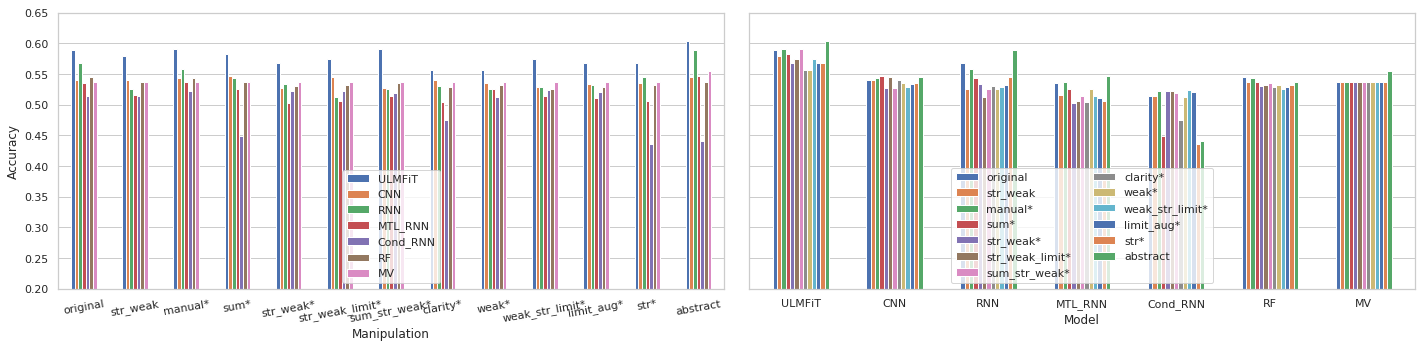

In [0]:
fig, axes = plt.subplots(nrows=1, ncols=2, sharey='row', figsize=(20,5))
# fig.suptitle("smth")
  
df_aspect = df_all_epoch_no_0.groupby(["Manipulation", "Model", "Aspect"], sort=False).agg({"Accuracy":"median"}).unstack().mean(axis=1).unstack().plot.bar(rot=10, ax=axes[0])

df_aspect_1 = df_all_epoch_no_0.groupby(["Manipulation", "Model", "Aspect"], sort=False).agg({"Accuracy":"median"}).unstack().mean(axis=1).unstack().T.plot.bar(rot=0, ax=axes[1],  width=0.6)
  
plt.tight_layout()
 
# axes[0].set_title("title")
# axes[1].set_title("title")

axes[0].set_ylabel("Accuracy")

axes[0].legend(loc='lower center')
axes[1].legend(loc='lower center', ncol=2)

axes[0].grid(False, axis="x")
axes[1].grid(False, axis="x")

plt.yticks(np.arange(0, 0.7, step=0.05))
plt.ylim(bottom=0.2)
plt.tight_layout()

# plt.savefig("aggperformance", dpi=300)

## Detailed plots

#### Baseline Perormance plot 

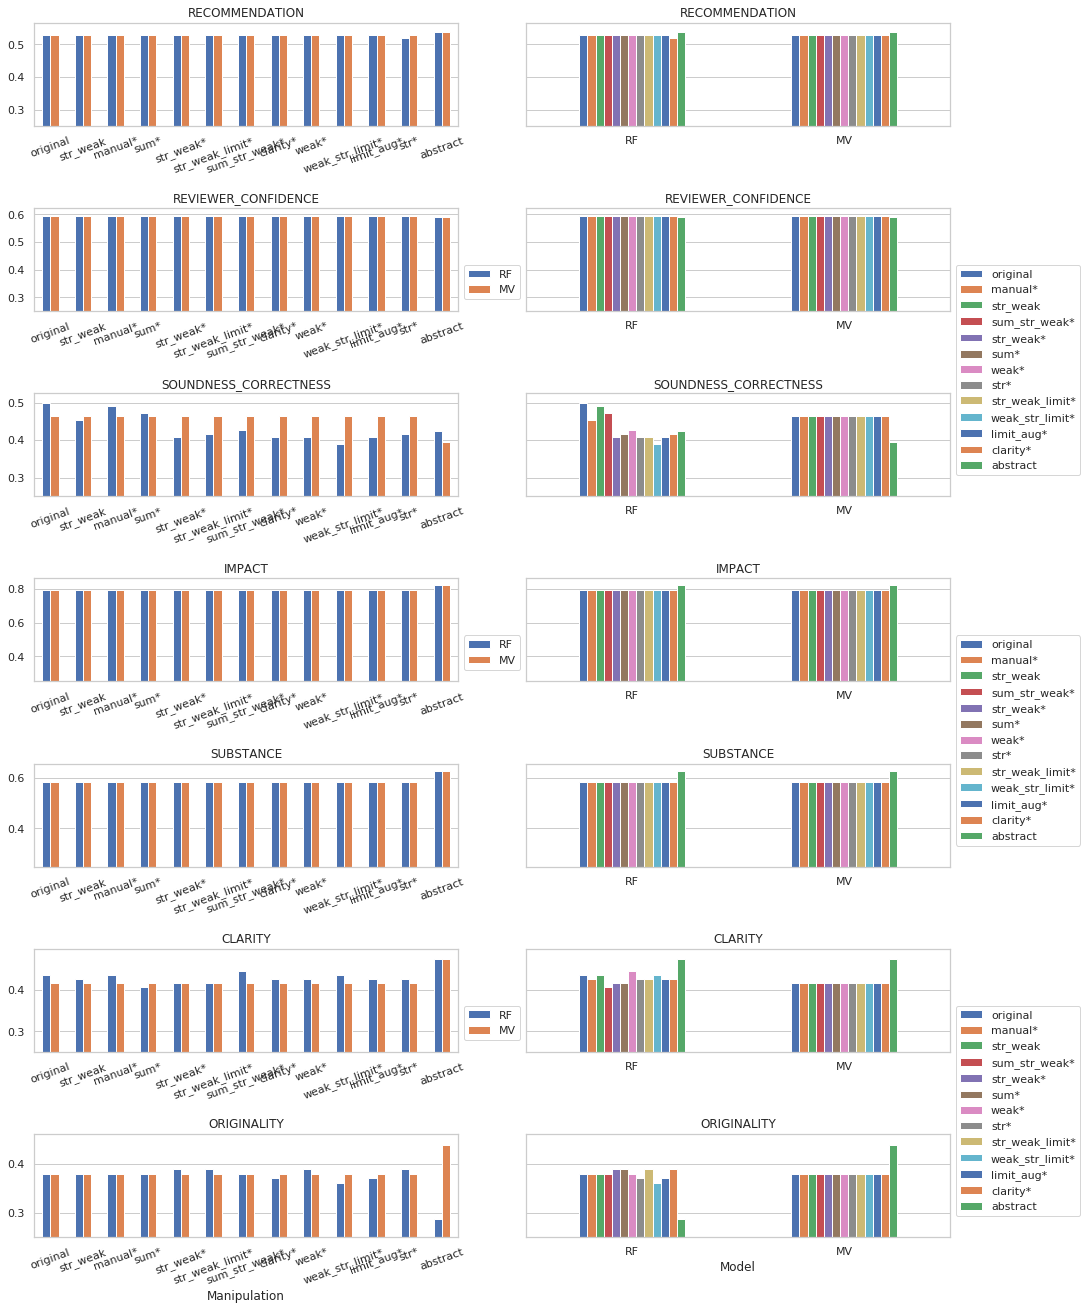

In [0]:
fig, axes = plt.subplots(nrows=7, ncols=ncols_aspect, sharey='row', figsize=(15,18))
# fig.suptitle("smth", fontsize=16)
  
for ax_idx, aspect in enumerate(env_var.aspects_no_com_approp):
  
  df_aspect = df[((df.Model == "MV") | (df.Model == "RF")) & (df.Aspect == aspect)].groupby(["Manipulation", "Model"], sort=False).agg({"Accuracy":"median"}).unstack()
  
  df_aspect_1 = df[((df.Model == "MV") | (df.Model == "RF")) & (df.Aspect == aspect)].groupby(["Model", "Manipulation"], sort=False).agg({"Accuracy":"median"}).unstack()
  
  axes[ax_idx,0].set_title(aspect)
  axes[ax_idx,1].set_title(aspect)
  
  df_aspect.plot.bar(rot=20, ax=axes[ax_idx,0])
  df_aspect_1.plot.bar(rot=0, ax=axes[ax_idx,1])
  
  if ax_idx % 2 == 1:
    axes[ax_idx,0].legend(["RF", "MV"], loc='upper left', bbox_to_anchor=(1.0, 0.5))
    axes[ax_idx,1].legend(manipulations_order, loc='upper left', bbox_to_anchor=(1.0, 0.5))
  else:
    axes[ax_idx,0].get_legend().remove()
    axes[ax_idx,1].get_legend().remove()

  axes[ax_idx,0].set_ylim(bottom=0.25)
  axes[ax_idx,1].set_ylim(bottom=0.25)
  
  if ax_idx < len(env_var.aspects_no_com_approp) - 1:
    axes[ax_idx,0].set_xlabel("")
    axes[ax_idx,1].set_xlabel("")
    
  axes[ax_idx,0].grid(False, axis="x")
  axes[ax_idx,1].grid(False, axis="x")

plt.ylabel("Accuracy")
# plt.yticks(np.arange(0, 0.7, step=0.05))
# plt.legend('')
plt.tight_layout(0,-7.5)

# plt.savefig("test", dpi=300)

#### Perormance plot Overview

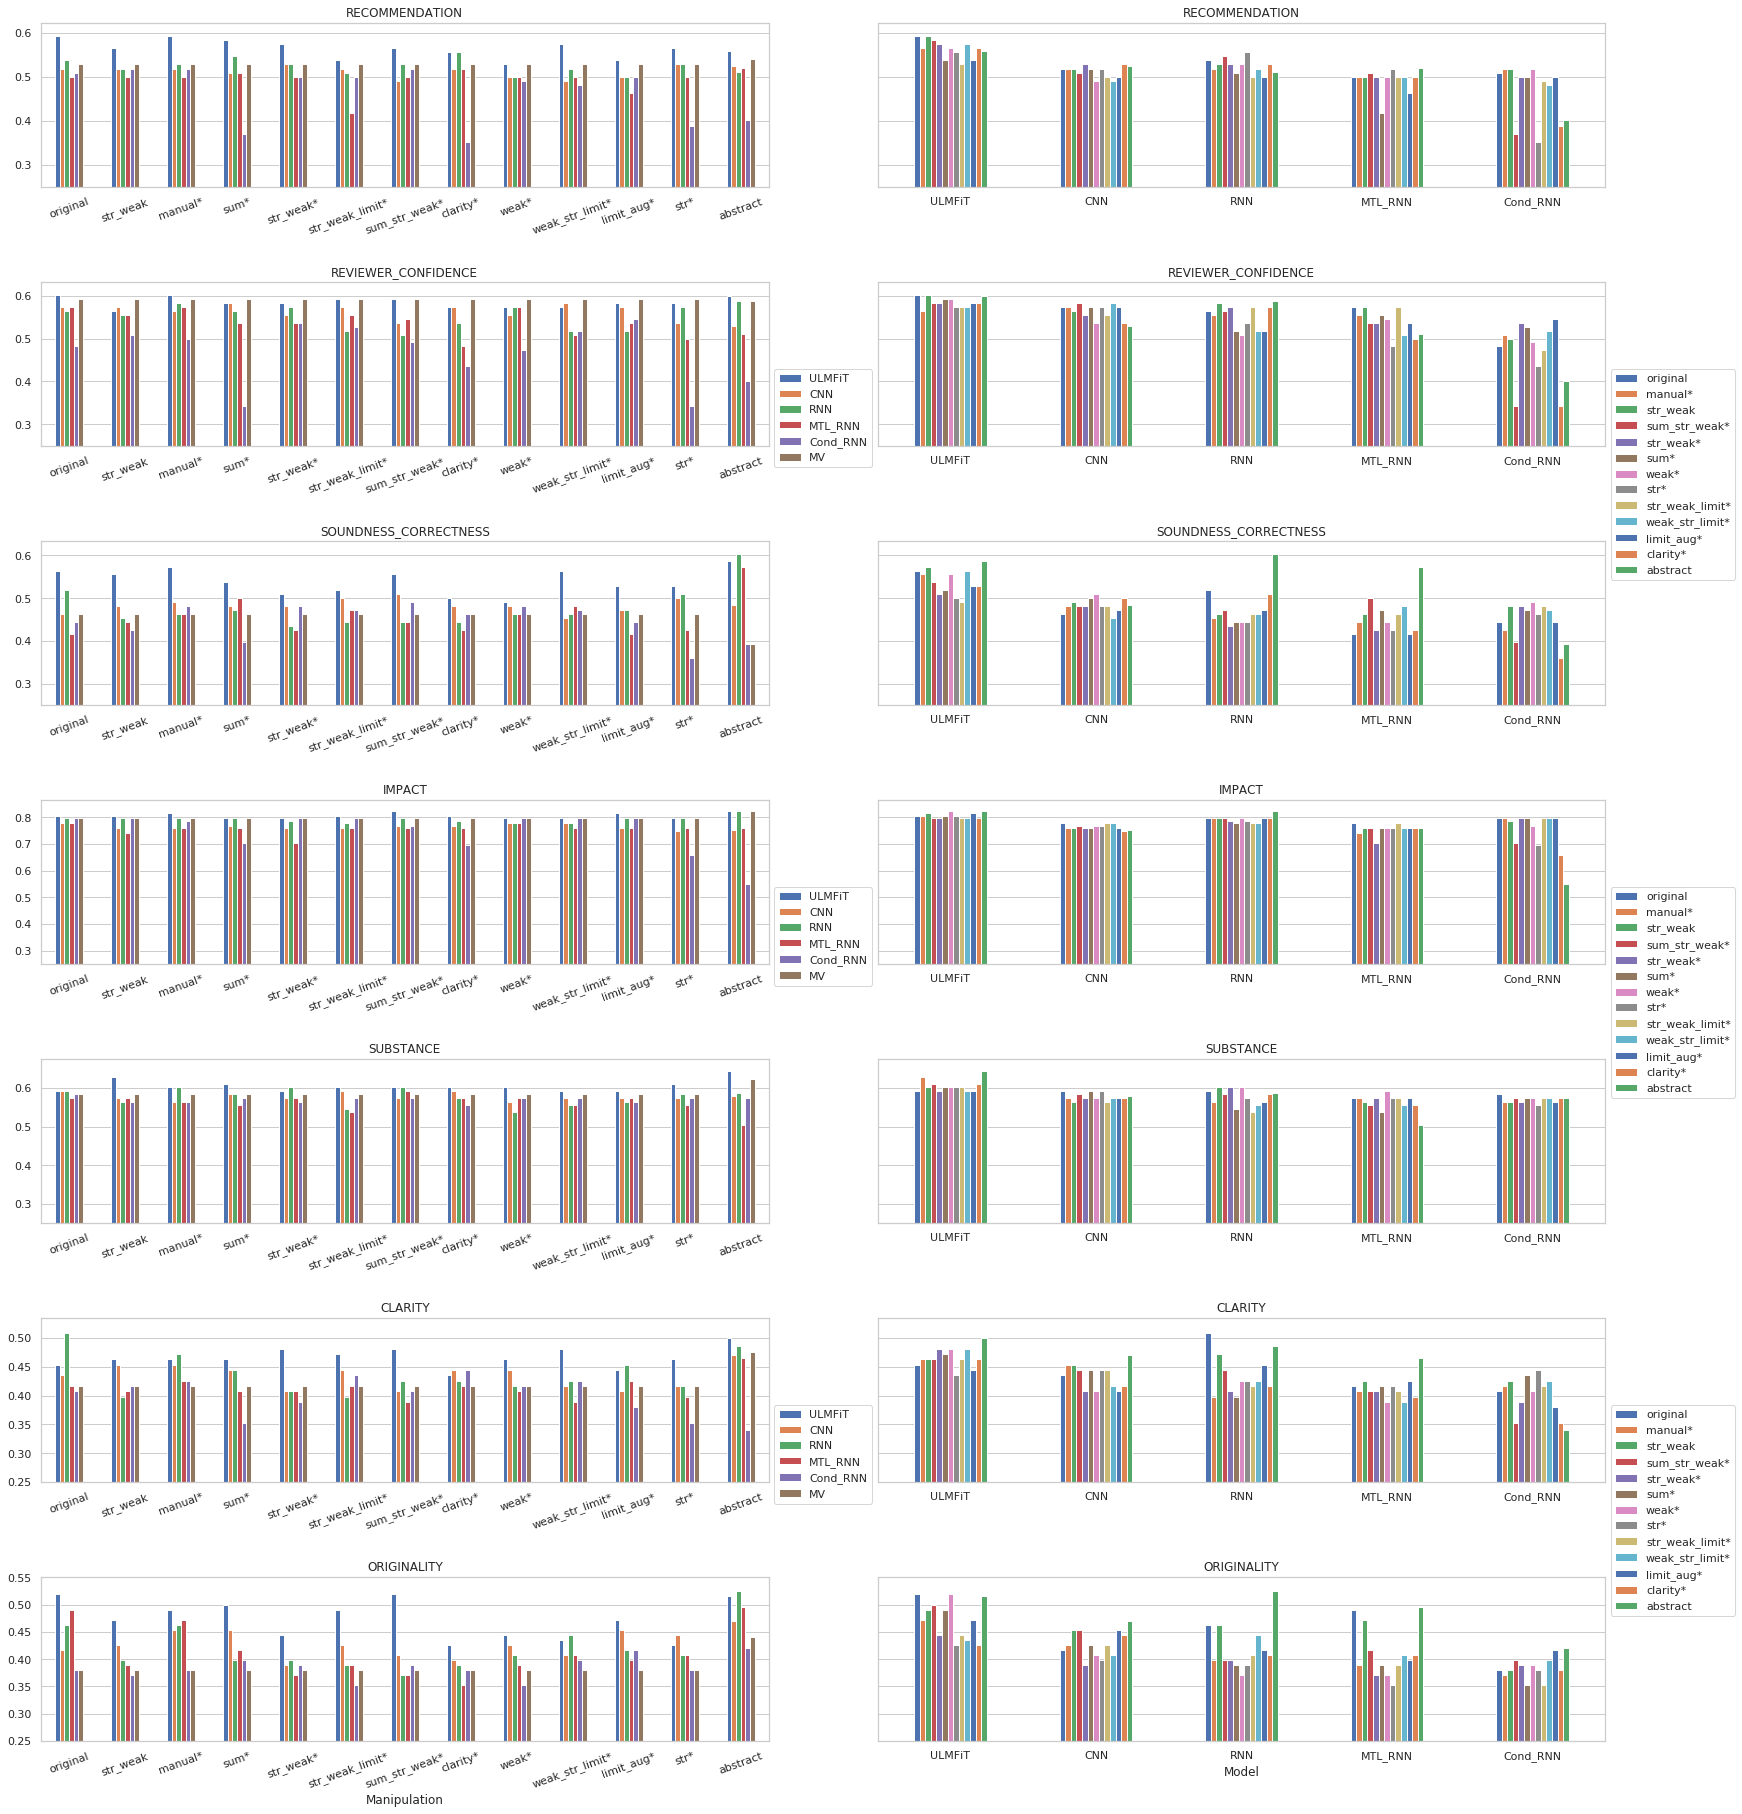

In [0]:
fig, axes = plt.subplots(nrows=7, ncols=ncols_aspect, sharey='row', figsize=(24,25))
# fig.suptitle("smth", fontsize=16)
  
for ax_idx, aspect in enumerate(env_var.aspects_no_com_approp):
  
  df_aspect = df[((df.Epoch != 0) | (df.Model == "MV")) & (df.Aspect == aspect)].groupby(["Manipulation", "Model"], sort=False).agg({"Accuracy":"median"}).unstack()
  
  df_aspect_1 = df[(df.Epoch != 0) & (df.Aspect == aspect)].groupby(["Model", "Manipulation"], sort=False).agg({"Accuracy":"median"}).unstack()
  
  axes[ax_idx,0].set_title(aspect)
  axes[ax_idx,1].set_title(aspect)
  
  df_aspect.plot.bar(rot=20, ax=axes[ax_idx,0])
  df_aspect_1.plot.bar(rot=0, ax=axes[ax_idx,1])
  
  if ax_idx % 2 == 1:
    axes[ax_idx,0].legend(["ULMFiT", "CNN", "RNN", "MTL_RNN", "Cond_RNN", "MV"], loc='upper left', bbox_to_anchor=(1.0, 0.5))
    axes[ax_idx,1].legend(manipulations_order, loc='upper left', bbox_to_anchor=(1.0, 0.5))
  else:
    axes[ax_idx,0].get_legend().remove()
    axes[ax_idx,1].get_legend().remove()

  axes[ax_idx,0].set_ylim(bottom=0.25)
  axes[ax_idx,1].set_ylim(bottom=0.25)
  
  if ax_idx < len(env_var.aspects_no_com_approp) - 1:
    axes[ax_idx,0].set_xlabel("")
    axes[ax_idx,1].set_xlabel("")
    
  axes[ax_idx,0].grid(False, axis="x")
  axes[ax_idx,1].grid(False, axis="x")
#   break

plt.ylabel("Accuracy")
# plt.yticks(np.arange(0, 0.7, step=0.05))
# plt.legend('')
plt.tight_layout(0,-4.5)

plt.savefig("overviewofdetails", dpi=300)

#### Models Perormance plot 

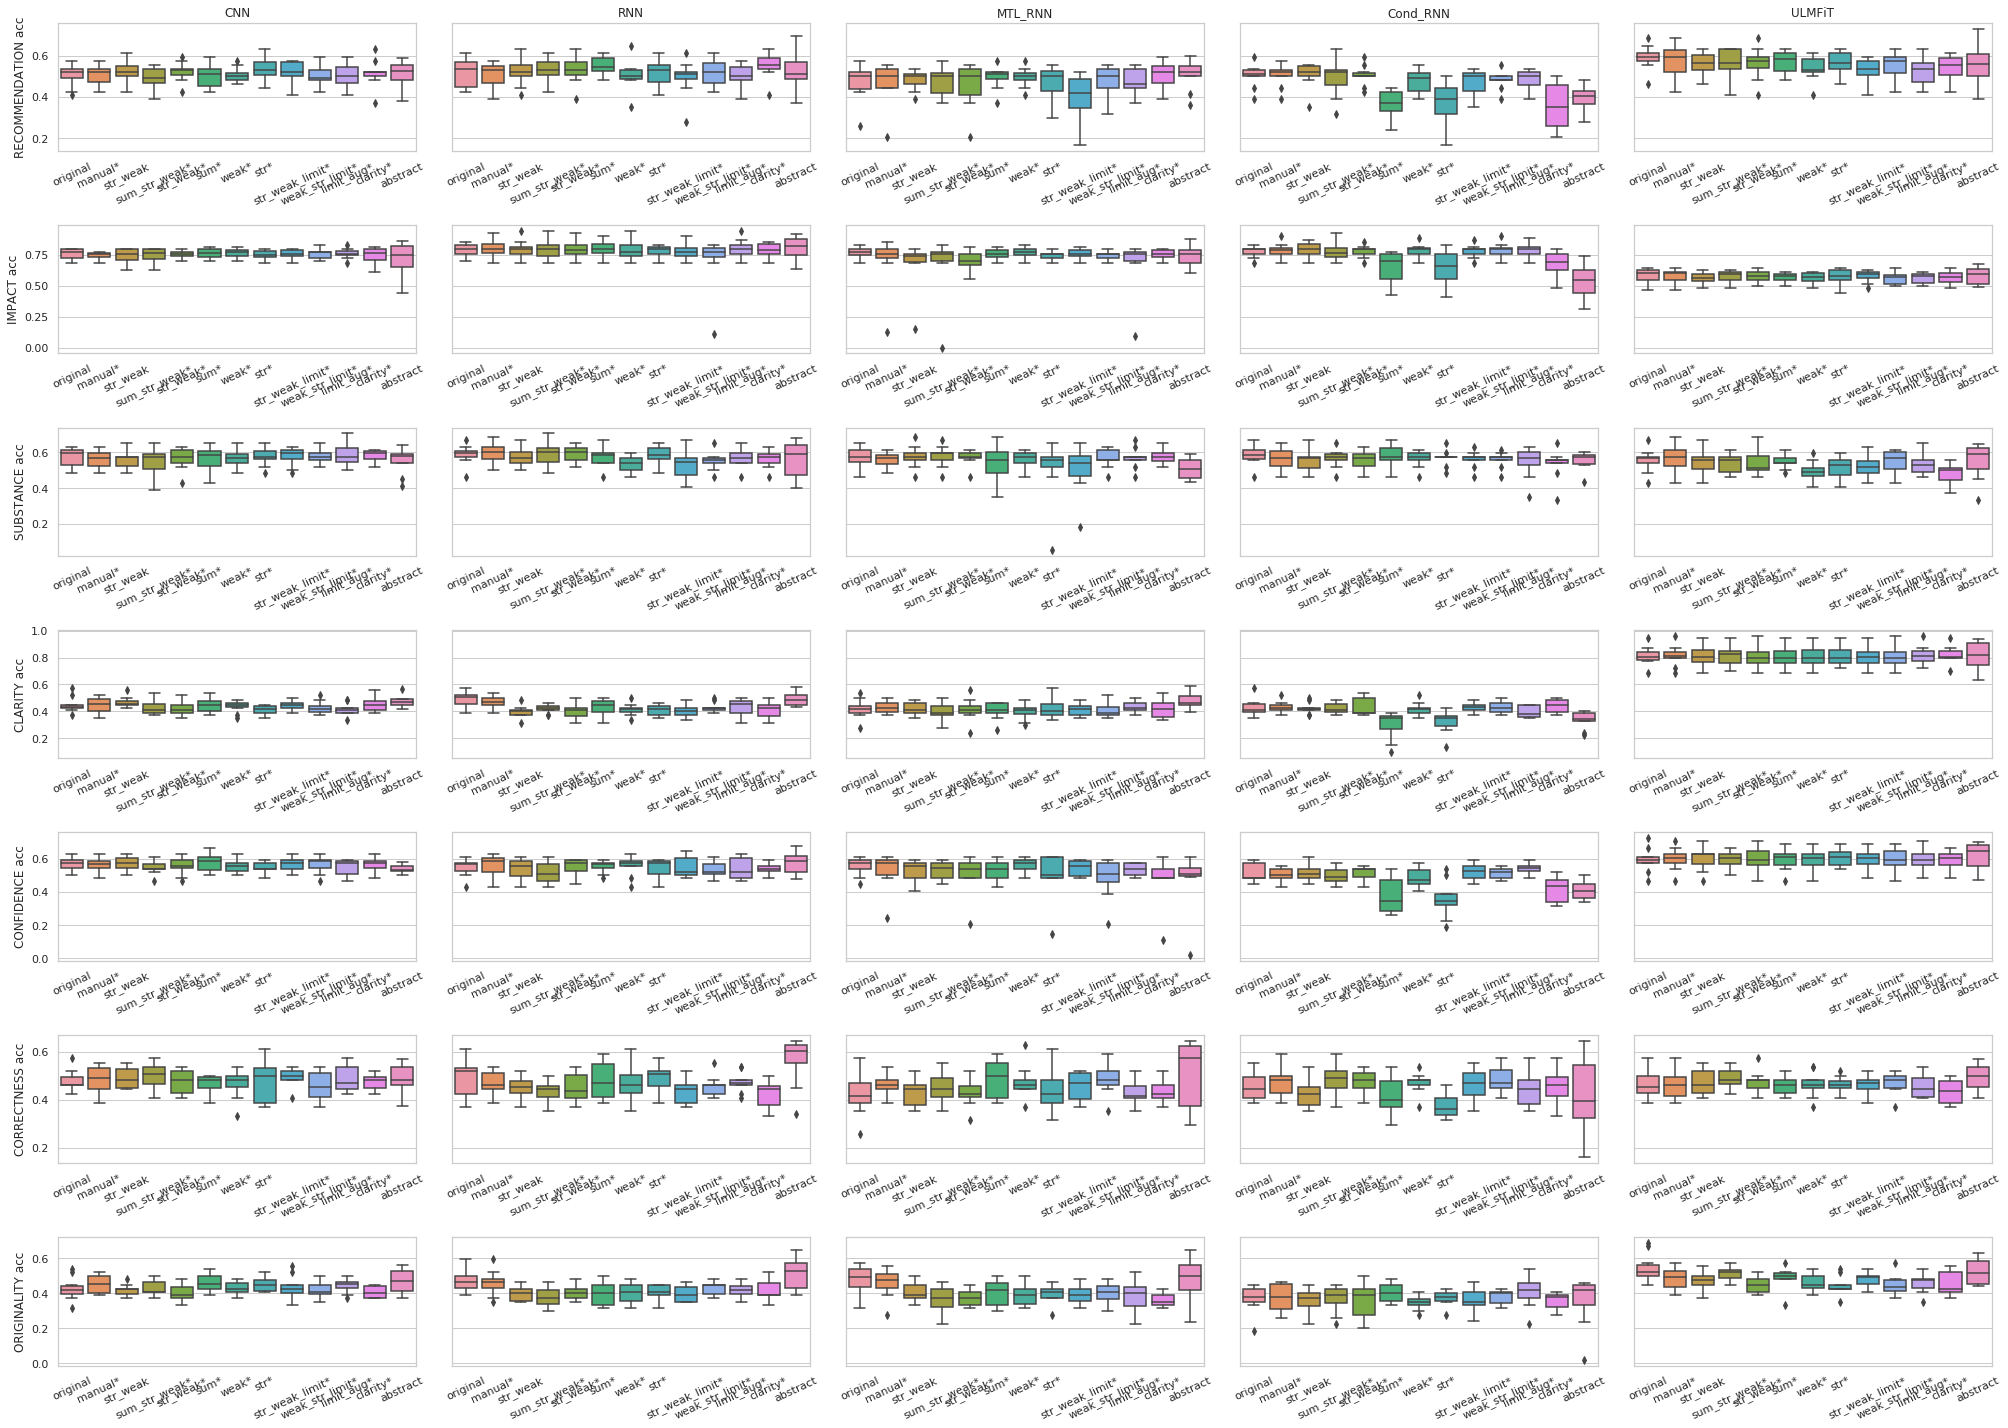

In [0]:
nrows_single, ncols_single = (len(env_var.aspects_no_com_approp), len(models))

fig, axes = plt.subplots(nrows=nrows_single, ncols=ncols_single, figsize=(28, 20), sharey="row")

for model_idx, model_name in enumerate(models):
  
  df_model = df[(df.Epoch != 0) & (df.Model == model_name)].groupby(["Aspect"], sort=False)
  
  for ax_idx, (aspect, group) in enumerate(df_model):
    
    i_j = (ax_idx, model_idx) 

    axes[i_j].set_title(aspect)

    g = sns.boxplot(x="Manipulation", y="Accuracy", data=group, ax=axes[i_j], order=manipulations_order)
    g.set_xticklabels(g.get_xticklabels(), rotation=25)
    g.set_xlabel("")
    
    
    if model_idx == 0:
      aspect_title = aspect
      if "_" in aspect:
        aspect_title = aspect.split("_")[1]
        
      g.set_ylabel(aspect_title + " acc")
    else:
      g.set_ylabel("")
    
    if ax_idx == 0:
      g.set_title(model_name)
    else:
      g.set_title("")
    
    
#     plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.tight_layout()

plt.savefig("modelonmanipulation", dpi=300)

#### Manipulated ACL reviews Perormance plot 

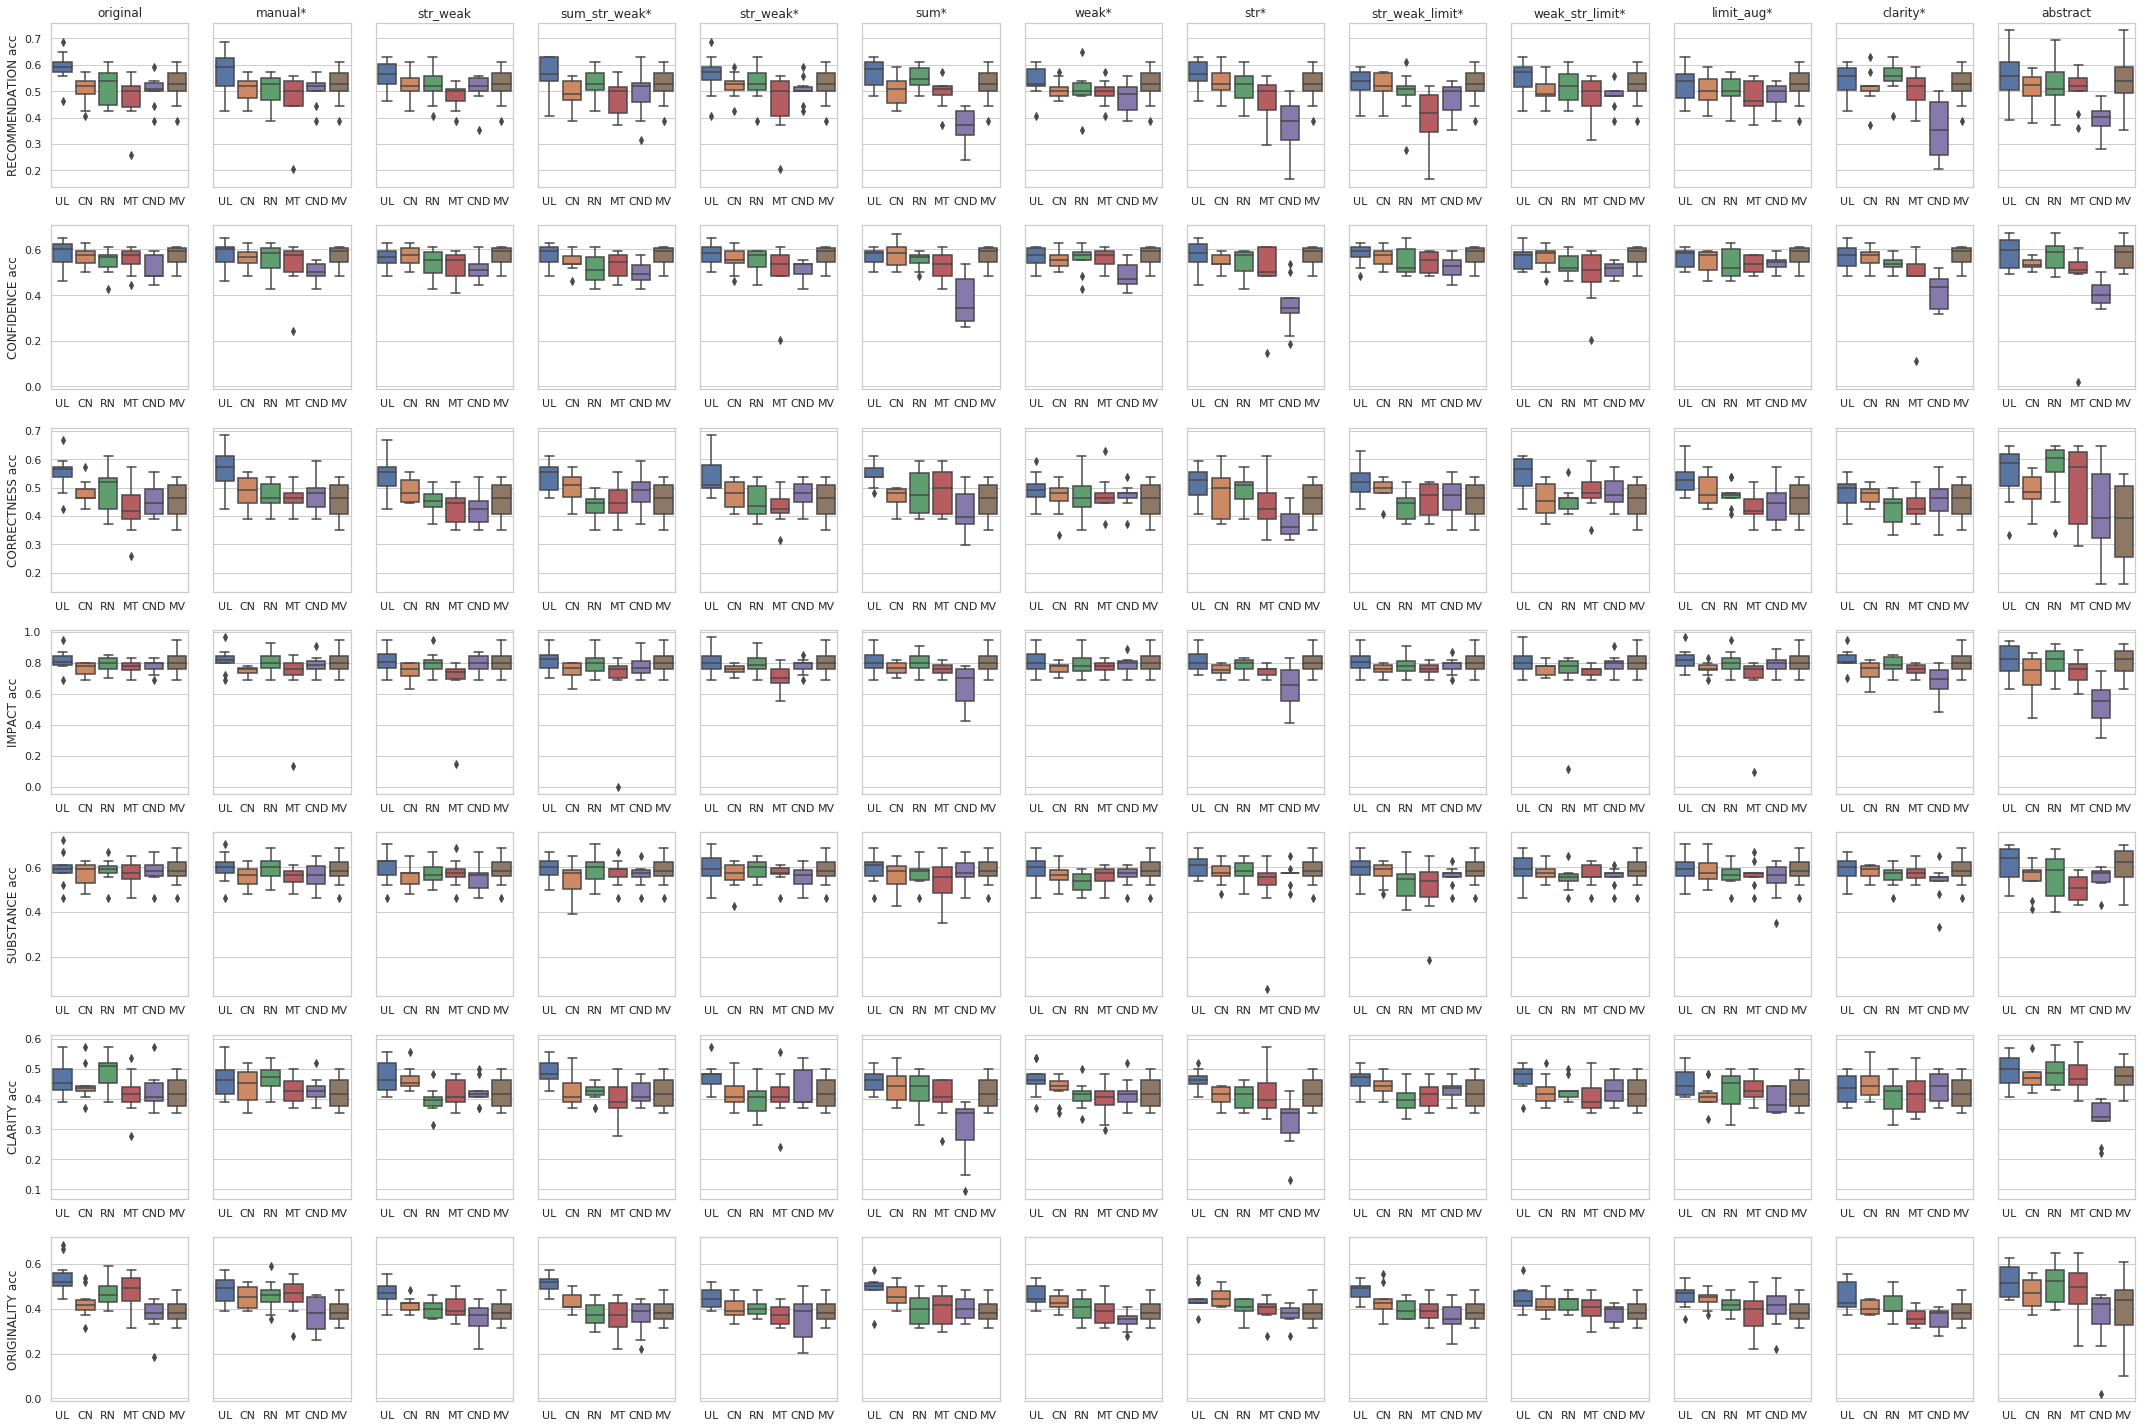

In [0]:
#### Manipulated ACL reviews Perormance plot 

nrows_single, ncols_single = (7, 13)

fig, axes = plt.subplots(nrows=nrows_single, ncols=ncols_single, figsize=(30, 20), sharey="row")
# fig.suptitle("title", fontsize=16)

for manipulation_idx, manipulation in enumerate(manipulations_order):
  
  df_manipulation = df[((df.Epoch != 0) | (df.Model == "MV")) & (df.Manipulation == manipulation)].groupby(["Aspect"], sort=False)

  for ax_idx, (aspect, group) in enumerate(df_manipulation):

    i_j = (ax_idx, manipulation_idx) 

    axes[i_j].set_title(aspect)

    g = sns.boxplot(x="Model", y="Accuracy", data=group, ax=axes[i_j])

    g.set_xticklabels(['UL', 'CN', 'RN', 'MT', 'CND', 'MV'])
      
  #   g.set_xticklabels(g.get_xticklabels(), rotation=20)
    g.set_xlabel("")
    
    if manipulation_idx == 0:
      aspect_title = aspect
      if "_" in aspect:
        aspect_title = aspect.split("_")[1]
        
      g.set_ylabel(aspect_title + " acc")
    else:
      g.set_ylabel("")
    
    if ax_idx == 0:
      g.set_title(manipulation)
    else:
      g.set_title("")
      
plt.tight_layout()
    
plt.savefig("modelcomparison", dpi=300)

#### Convergence plot

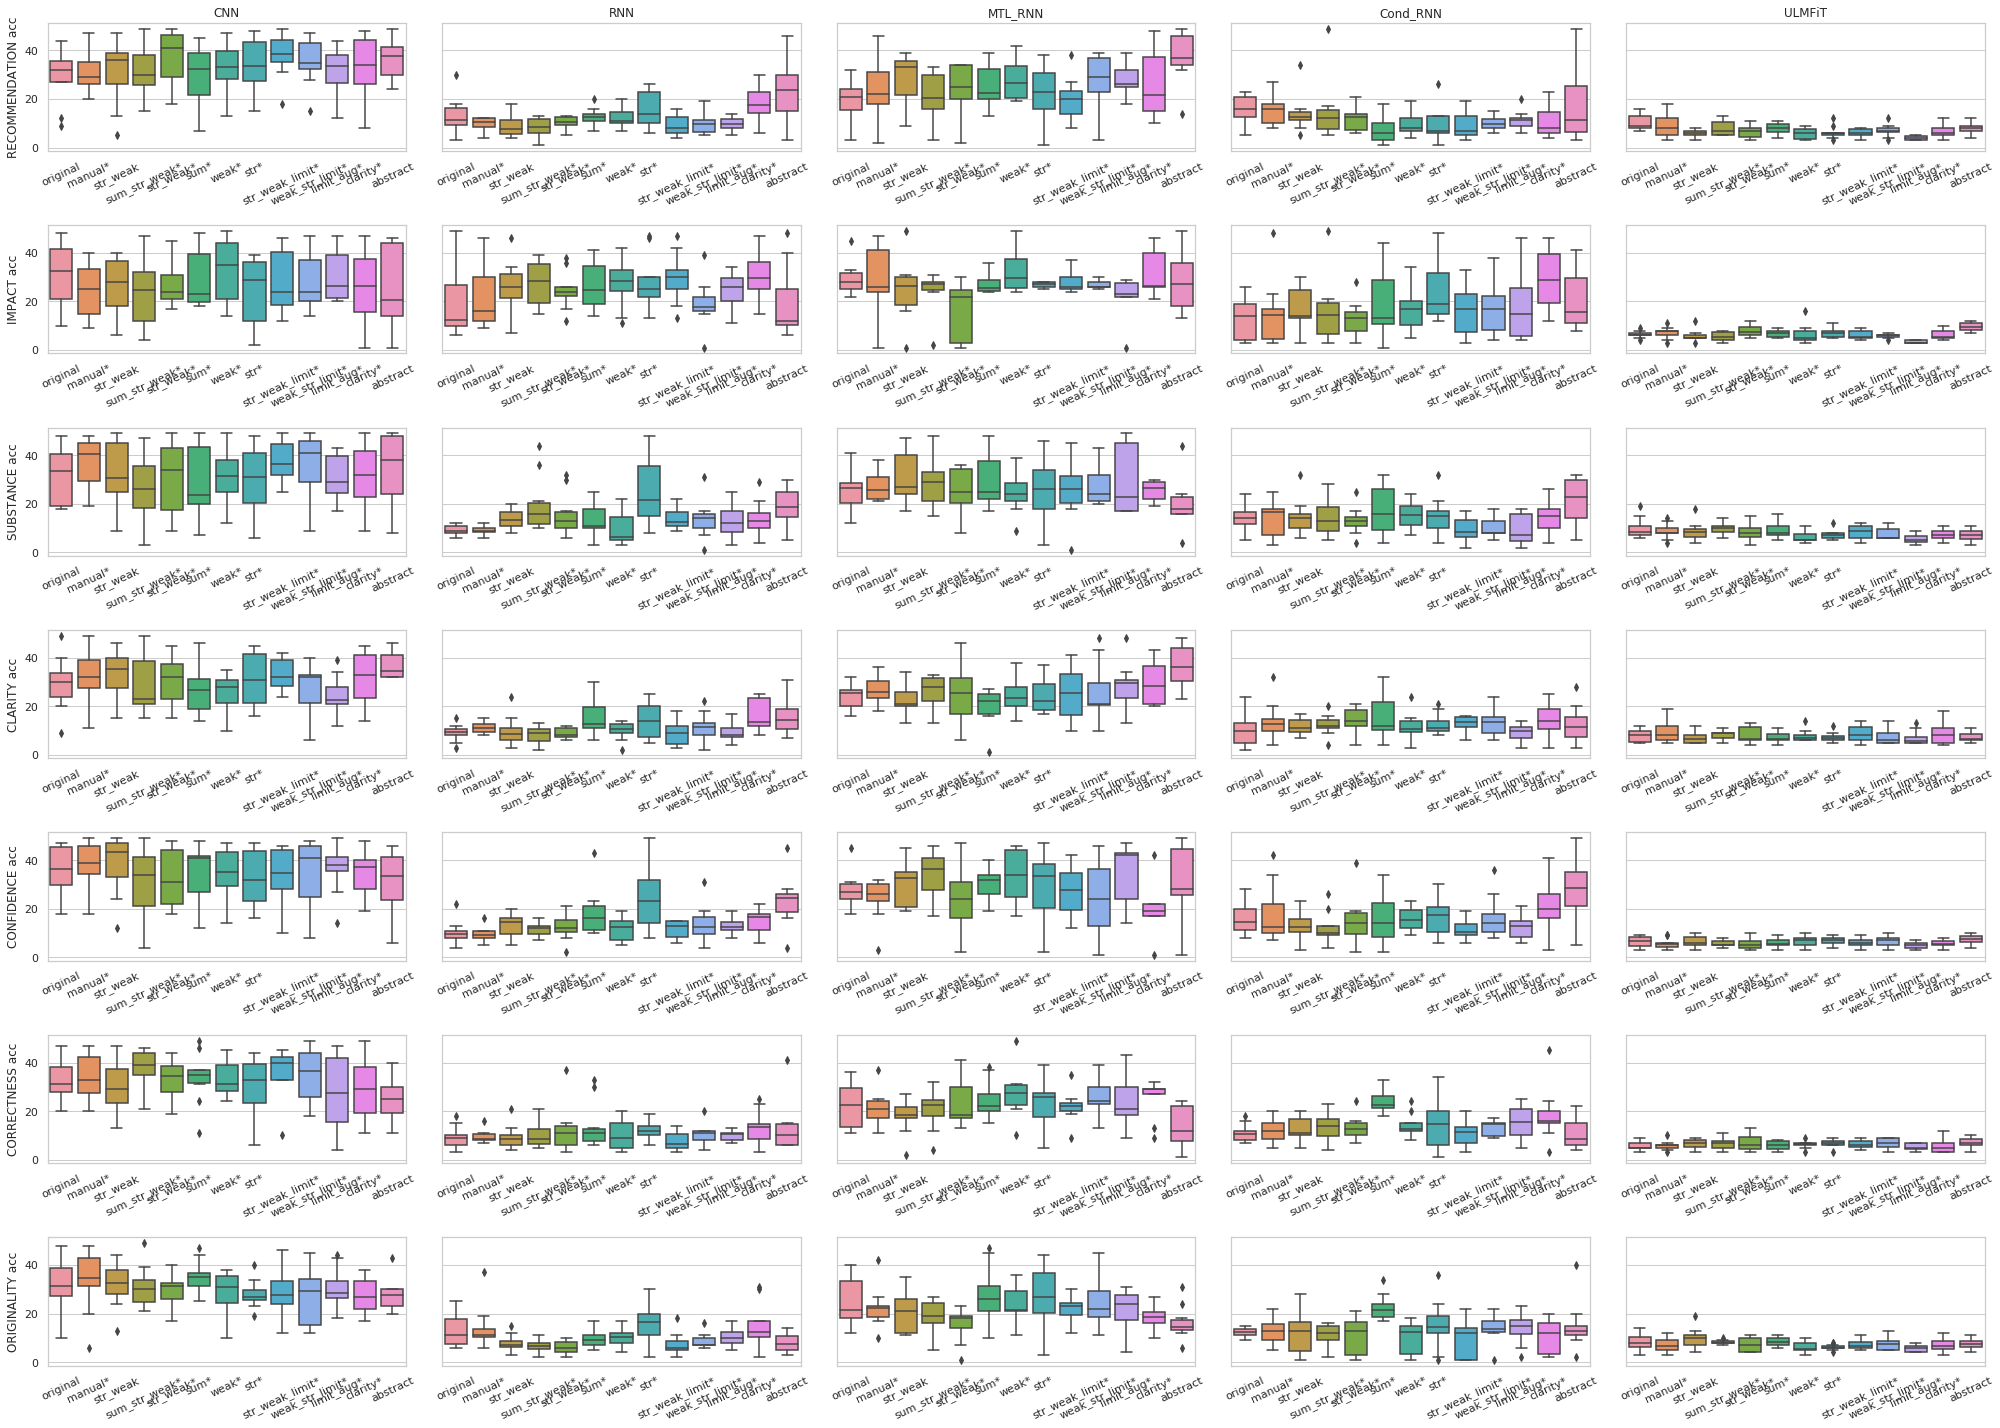

In [0]:
nrows_single, ncols_single = (len(env_var.aspects_no_com_approp), len(models))

fig, axes = plt.subplots(nrows=nrows_single, ncols=ncols_single, figsize=(28, 20), sharey="row")

for model_idx, model_name in enumerate(models):
  
  df_model = df[(df.Epoch != 0) & (df.Model == model_name)].groupby(["Aspect"], sort=False)
  
  for ax_idx, (aspect, group) in enumerate(df_model):
    
    i_j = (ax_idx, model_idx) 

    axes[i_j].set_title(aspect)

    g = sns.boxplot(x="Manipulation", y="Epoch", data=group, ax=axes[i_j], order=manipulations_order)
    g.set_xticklabels(g.get_xticklabels(), rotation=25)
    g.set_xlabel("")
    
    
    if model_idx == 0:
      aspect_title = aspect
      if "_" in aspect:
        aspect_title = aspect.split("_")[1]
        
      g.set_ylabel(aspect_title + " acc")
    else:
      g.set_ylabel("")
    
    if ax_idx == 0:
      g.set_title(model_name)
    else:
      g.set_title("")
    
    
#     plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.tight_layout()

plt.savefig("convergence", dpi=300)

In [0]:
df[(df.Epoch != 0)].groupby(["Model", "Manipulation"], sort=False).agg({"Epoch": ["mean"]}).unstack()

Epoch                        ...                                 
                   mean                        ...                                 
Manipulation   original   str_weak    manual*  ... limit_aug*       str*   abstract
Model                                          ...                                 
ULMFiT         7.885714   7.214286   7.628571  ...   5.128571   6.785714   7.728571
CNN           31.764706  32.117647  33.223881  ...  30.220588  30.250000  30.925373
RNN           11.842857  12.671429  12.128571  ...  12.814286  19.173913  17.400000
MTL_RNN       24.730159  24.559322  24.921875  ...  26.483871  25.214286  26.067797
Cond_RNN      13.202899  13.400000  14.414286  ...  12.785714  15.470588  17.823529

[5 rows x 13 columns]

In [0]:
df[(df.Epoch == 0) & (df.Model != "RF") & (df.Model != "MV")].groupby(["Model", "Manipulation"], sort=False).agg({"Epoch": ["count"]}).unstack()

Epoch                   ...                          
                count                   ...                          
Manipulation original str_weak manual*  ... limit_aug*  str* abstract
Model                                   ...                          
CNN               2.0      2.0     3.0  ...        2.0   2.0      3.0
MTL_RNN           7.0     11.0     6.0  ...        8.0  14.0     11.0
Cond_RNN          1.0      NaN     NaN  ...        NaN   2.0      2.0
RNN               NaN      NaN     NaN  ...        NaN   1.0      NaN

[4 rows x 13 columns]

In [0]:
print(df[(df.Epoch == 0) & (df.Model != "RF") & (df.Model != "MV")].groupby(["Model", "Manipulation"], sort=False).agg({"Epoch": ["count"]}).unstack().to_latex())